Machine_Learning_Pipeline 

In [1]:
# Data Management/Investigation
import pandas as pd
from pandas.api.types import CategoricalDtype # Ordering categories
import numpy as np
import missingno as miss

# Plotting libraries
from plotnine import *
import matplotlib.pyplot as plt

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.tree import DecisionTreeRegressor as DT_reg
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn import tree # For plotting the decision tree rules

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# For model interpretation
from sklearn.inspection import (
    permutation_importance,
    partial_dependence, 
    PartialDependenceDisplay, 
    plot_partial_dependence
)

# Misc
import warnings
warnings.filterwarnings("ignore")

### 1. Split the data into a training and test dataset partitioning 75% of the data into the training data, and holding out 25% of the data as a test set. Set a seed to replicate your split using 202011.

In [2]:
# Set seed
np.random.seed(202011)

# readd in data
credit_dat = pd.read_csv("credit_data.csv")

# Train-Test split (just using Pandas)
train = credit_dat.sample(frac=.75).reset_index(drop=True)
test = credit_dat.drop(train.index).reset_index(drop=True)
# Print off the split count 
print("Training Data:",train.shape[0],
      "\nTest Data:",test.shape[0])

# Look at the head of the data
train.head()

Training Data: 3340 
Test Data: 1114


,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,good,13,owner,36,50,married,no,fixed,45,139.0,1800.0,0.0,715,1683
1,good,16,owner,48,31,married,no,fixed,45,200.0,5000.0,800.0,1250,1646
2,good,24,owner,18,38,married,yes,fixed,45,NaN,7000.0,90.0,300,400
3,good,22,owner,6,46,married,no,freelance,90,150.0,75000.0,0.0,3000,3300
4,bad,5,rent,60,31,married,yes,fixed,69,88.0,0.0,0.0,1200,1200


### 2. Examine the training data. 

In [3]:
credit_dat.shape##checking the data structure 

(4454, 14)

In [4]:
credit_dat.head()##look into the data 

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,good,9,rent,60,30,married,no,freelance,73,129.0,0.0,0.0,800,846
1,good,17,rent,60,58,widow,no,fixed,48,131.0,0.0,0.0,1000,1658
2,bad,10,owner,36,46,married,yes,freelance,90,200.0,3000.0,0.0,2000,2985
3,good,0,rent,60,24,single,no,fixed,63,182.0,2500.0,0.0,900,1325
4,good,0,rent,36,26,single,no,fixed,46,107.0,0.0,0.0,310,910


<AxesSubplot:>

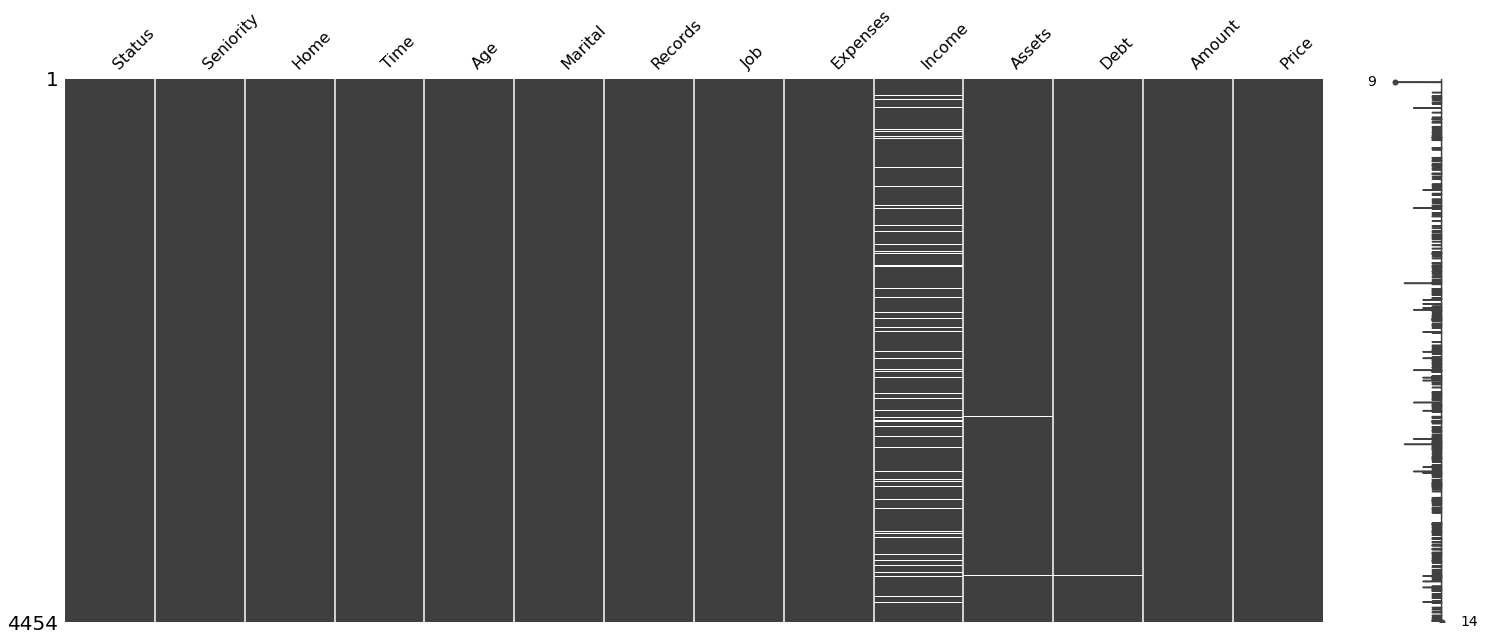

In [5]:
##checking missing data 
miss.matrix(credit_dat)

In [6]:
#Fill the missing value with mode 
credit_dat['Income'].fillna(credit_dat['Income'].mode()[0], inplace=True)
credit_dat.dropna(inplace=True)f

In [7]:
credit_dat.dtypes##chcking the data types 

Status        object
Seniority      int64
Home          object
Time           int64
Age            int64
Marital       object
Records       object
Job           object
Expenses       int64
Income       float64
Assets       float64
Debt         float64
Amount         int64
Price          int64
dtype: object

In [8]:
##Convert categorical variables to categories.
for col in ['Status', 'Home', 'Marital', 'Records',"Job"]:
    credit_dat[col] = credit_dat[col].astype('category')

<AxesSubplot:>

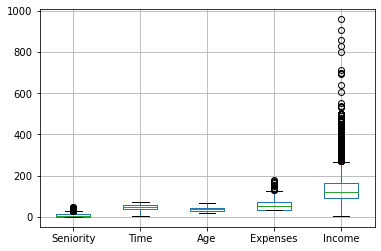

In [9]:
##checking oddities in the data
credit_dat.boxplot(column=["Seniority","Time","Age","Expenses","Income"])

<AxesSubplot:>

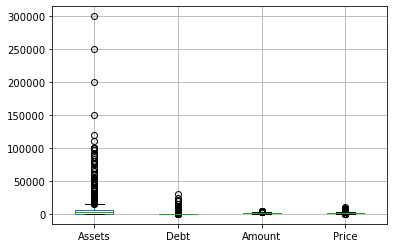

In [10]:
##checking oddities in the data
credit_dat.boxplot(column=["Assets","Debt","Amount","Price"])

Explore Training Set

In [11]:
##Split the data into traning and testing.
y = credit_dat[['Status']]
X = credit_dat.drop(columns=['Status'])
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .75,random_state=202011)

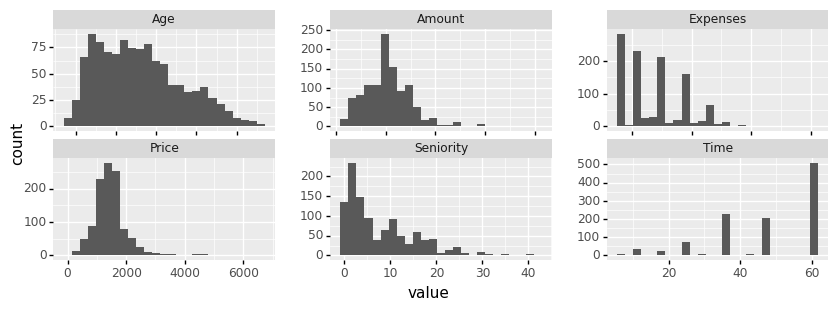

<ggplot: (133878473716)>

In [12]:
# Plot the continuous Variables 
d = train_X.select_dtypes(include="int64").melt()
(
    ggplot(d,aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,3),
          subplots_adjust={'wspace':0.25})
)

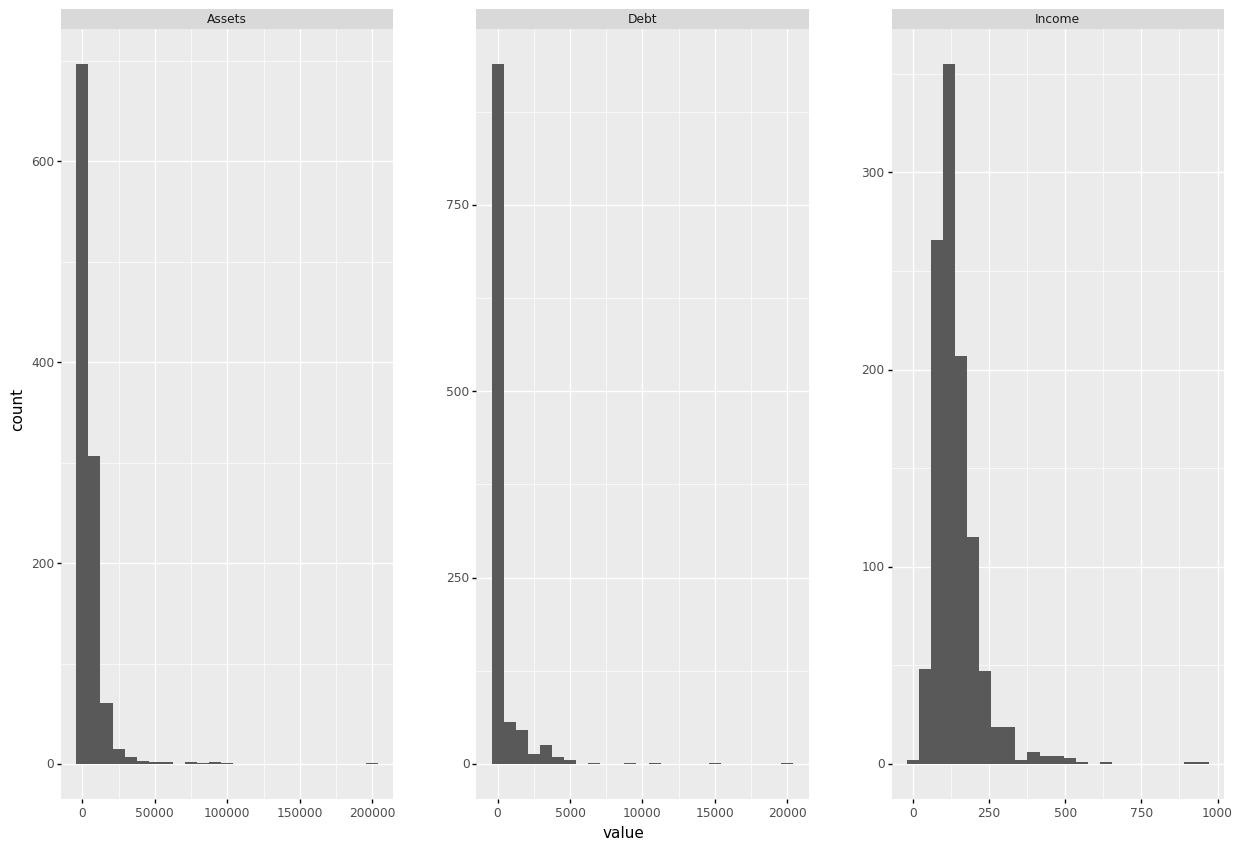

<ggplot: (133878659729)>

In [13]:
#Look at the distribution of float.
d = train_X.select_dtypes(include="float64").melt()

(
    ggplot(d,aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(15,10),
          subplots_adjust={'wspace':0.25})
)

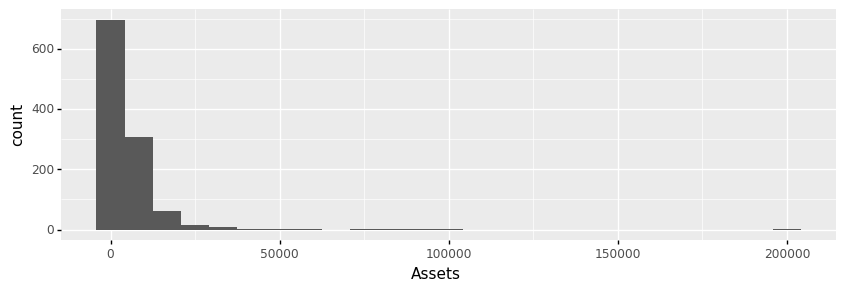

<ggplot: (133880392665)>

In [14]:
##log the assets column.
d = train_X.copy()
d['ln_Assets'] =  np.log(d['Assets'] + 1)
(
    ggplot(d,aes(x="Assets")) +
    geom_histogram(bins=25) +
    theme(figure_size=(10,3),
          subplots_adjust={'wspace':0.25})
)

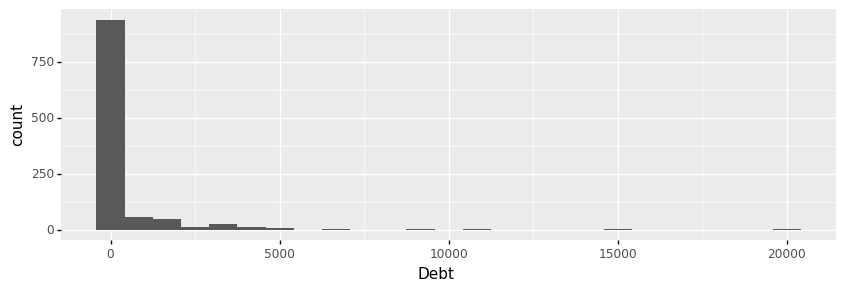

<ggplot: (133878652519)>

In [15]:
##log the debt column.
d = train_X.copy()
d['ln_Debt'] =  np.log(d['Debt'] + 1)
(
    ggplot(d,aes(x="Debt")) +
    geom_histogram(bins=25) +
    theme(figure_size=(10,3),
          subplots_adjust={'wspace':0.25})
)

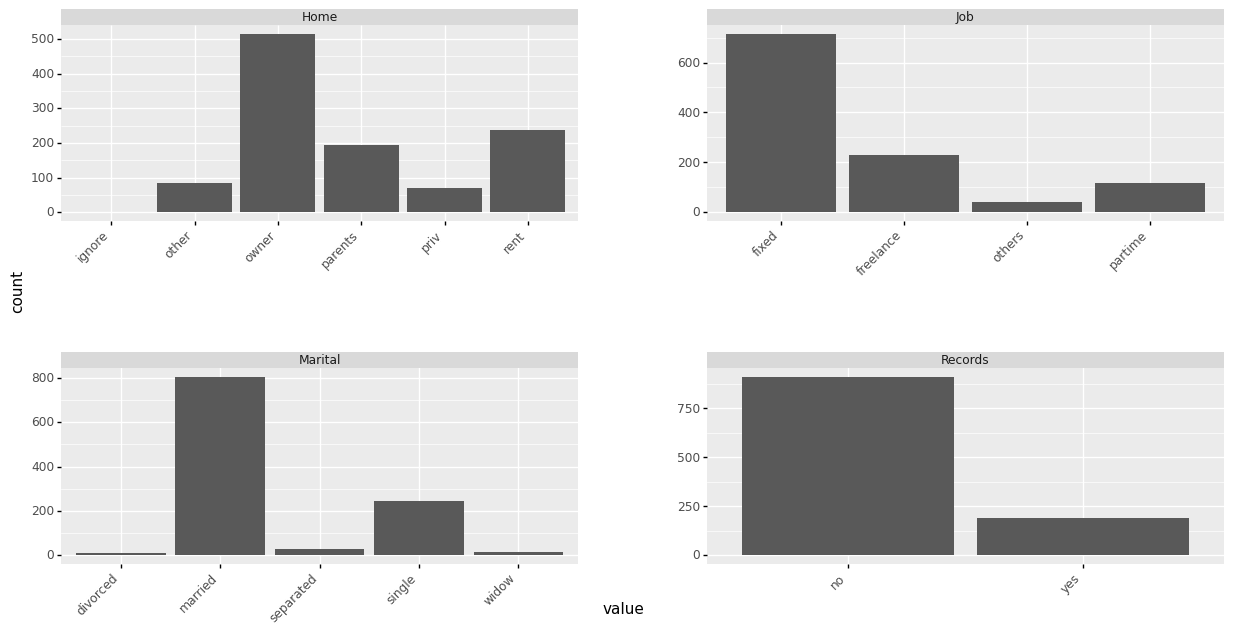

<ggplot: (133878665213)>

In [16]:
##look at the categorical predictors
d = train_X.select_dtypes(include="category").melt()
(
    ggplot(d,aes(x="value")) +
    geom_bar() +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(15,7),
          subplots_adjust={'wspace':0.25,
                           'hspace':0.75},
         axis_text_x=element_text(rotation=45, hjust=1))
)

There are 14 variables and 4454 rows in the data. There are three main data ytpes: int, float and categorical. The unit of analysis is per person; variables expect "Time" and "Age", there are different level of abnormal value in the data,for variables such as "Income" and  "Assets", there are individuls have extrem high income and assets. There are many missing data in variable of "Income". I logged the variables of assets and debt since they have a left skewed tendency.

### 3.Build a machine learning Pipeline 

#### Pre-processes the data

##### Marital

In [17]:
#Look at the value count.
credit_dat.Marital.value_counts()

married      3207
single        965
separated     129
widow          66
divorced       38
Name: Marital, dtype: int64

In [18]:
#Only keep the married and single.
credit_dat['married'] = 1*(credit_dat['Marital'] == "married")
credit_dat['single'] = 1*(credit_dat['Marital'] == "single")

In [19]:
# Drop Marital.
credit_dat = credit_dat.drop(columns=["Marital"])

##### Job

In [20]:
#Look at the value count.
credit_dat.Job.value_counts()

fixed        2786
freelance    1002
partime       449
others        168
Name: Job, dtype: int64

In [21]:
##Convert all categorical variables in the data to numeric values 
#Convert Job to dummies
job_dummies = pd.get_dummies(credit_dat.Job)
job_dummies.columns = [c.lower().replace(" ","_") for c in job_dummies.columns]
job_dummies = job_dummies.drop(['others'],axis=1) # Baseline
job_dummies.head(5)

,fixed,freelance,partime
0,0,1,0
1,1,0,0
2,0,1,0
3,1,0,0
4,1,0,0


In [22]:
#Put them into the dataset.
credit_dat = pd.concat([credit_dat.drop(['Job'],axis=1),job_dummies],axis=1)

###### Home 

In [23]:
#Look at the value count.
credit_dat.Home.value_counts()

owner      2080
rent        969
parents     779
other       314
priv        243
ignore       20
Name: Home, dtype: int64

In [24]:
# collapse the Home categories, merge ignore with other 
credit_dat['owner'] = 1*(credit_dat['Home'] == "owner")
credit_dat['rent'] = 1*(credit_dat['Home'] == "rent")
# Everyone else ("other") is the baseline. 

In [25]:
# Drop Home
credit_dat = credit_dat.drop(columns=["Home"])

##### Records

In [26]:
##Convert to a dummy variable.
credit_dat["Records"].value_counts()

no     3643
yes     762
Name: Records, dtype: int64

In [27]:
credit_dat["Records"] = 1*(credit_dat["Records"] == "yes")

In [28]:
credit_dat["Records"].sum()

762

##### Status 

In [29]:
##Finally, our outcome coverage needs to be numeric (0/1)
credit_dat["Status"].value_counts()

good    3172
bad     1233
Name: Status, dtype: int64

In [30]:
##Convert to a dummy variable.
credit_dat['Status'] = 1*(credit_dat['Status']=='good')

In [31]:
credit_dat["Status"].sum()

3172

##### Assets & Debt

In [32]:
#Log the assets and debt columns.
credit_dat['Assets'] =  np.log(credit_dat['Assets'] + 1)
credit_dat['Debt'] =  np.log(credit_dat['Debt'] + 1)

#### Re-split

In [33]:
y = credit_dat[['Status']]
X = credit_dat.drop(columns=['Status'])
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=202011)

In [34]:
train_X.dtypes

Seniority      int64
Time           int64
Age            int64
Records        int32
Expenses       int64
Income       float64
Assets       float64
Debt         float64
Amount         int64
Price          int64
married        int32
single         int32
fixed          uint8
freelance      uint8
partime        uint8
owner          int32
rent           int32
dtype: object

#### Uses K-fold cross-validation with 5 folds

In [35]:
#Cross validation.
# Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=1234)

In [36]:
##Initialize Pipeline
pipe = Pipeline(steps=[('pre_process', pp.MinMaxScaler()),('model',None)])

#### Incorporates all models outlined in part 4

In [37]:
##Select Models & Tuning Parameters.
search_space = [
    
    # NaiveBayes
    {'model': [NB()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[5,10,25,50]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DT()],
     'model__max_depth':[2,3,4]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
    'model__max_depth':[2,3,4],
    'model__n_estimators':[500,1000,1500]}
    
]

### 4. Run the following supervised statistical learning algorithms using any subset of the feature variables

In [38]:
##Put it all together in a GridSearch
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='roc_auc',
                      n_jobs=4)

In [39]:
##And Run
search.fit(train_X,train_y.Status)

GridSearchCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [GaussianNB()]},
                         {'model': [KNeighborsClassifier()],
                          'model__n_neighbors': [5, 10, 25, 50]},
                         {'model': [DecisionTreeClassifier()],
                          'model__max_depth': [2, 3, 4]},
                         {'model': [RandomForestClassifier(max_depth=4,
                                                           n_estimators=1500)],
                          'model__max_depth': [2, 3, 4],
                          'model__n_estimators': [500, 1000, 1500]}],
             scoring='roc_auc')

Best ROC AUC.

In [40]:
##Best ROC AUC score.
search.best_score_

0.8310489044647094

In [41]:
#Show the best models parameters.
search.best_params_

{'model': RandomForestClassifier(max_depth=4, n_estimators=1500),
 'model__max_depth': 4,
 'model__n_estimators': 1500}

In [42]:
##Assign it to an object.
rf_mod = search.best_estimator_

Performance

In [43]:
m.roc_auc_score(train_y,rf_mod.predict_proba(train_X)[:,1])

0.8537330688180089

In [44]:
m.accuracy_score(train_y,rf_mod.predict(train_X))

0.789585225552528

### 5. Identify which model performed the best using the area under the ROC curve (AUC) metric. Comment briefly about which model performed the best.

The model of random forest performs the best with the highest AUC of 0.823, and with 4 depth and 1500 estimators.

### 6. For the most predictive model, do the following 

#### (a) Examine the variable importance, which three variables does the model rely on most when making predictions

In [45]:
##Permute the features to determine importance.
vi = permutation_importance(rf_mod,train_X,train_y,n_repeats=5)

In [46]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,Records,0.028520,0.001870,0.024779,0.032260
1,Seniority,0.021617,0.003794,0.014029,0.029205
2,partime,0.018286,0.001719,0.014848,0.021725
3,Income,0.015864,0.003941,0.007982,0.023746
4,fixed,0.013503,0.002221,0.009060,0.017946
5,Amount,0.011202,0.002329,0.006543,0.015861
6,Assets,0.010475,0.002609,0.005258,0.015693
7,Time,0.004723,0.001466,0.001791,0.007655
8,owner,0.003633,0.001381,0.000872,0.006395
9,Price,0.002604,0.000593,0.001417,0.003790


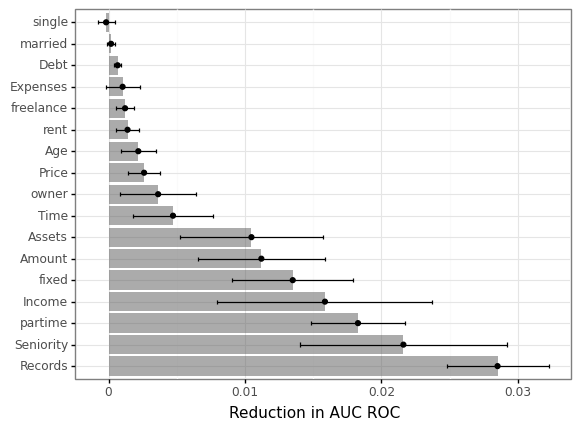

<ggplot: (133878665201)>

In [47]:
# Plot
(
    ggplot(vi_dat,
          aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)

The top three most important variables are Records, Seniority and partime.

#### (b) Plot partial dependency plots for the top three most important variable. What does the marginal relationship tell you?

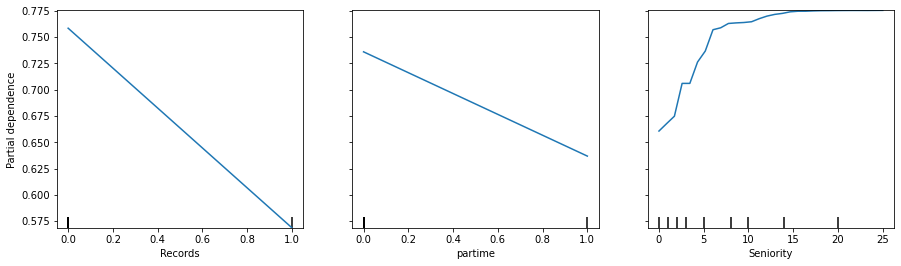

In [48]:
# Target specific features
features = ['Records','partime', 'Seniority']

# Calculate the partial dependency
fig, ax = plt.subplots(figsize=(15, 4))
display = plot_partial_dependence(
    rf_mod, train_X, features,n_cols=5,
    n_jobs=4, grid_resolution=30,ax=ax
)
# display.figure_.set_figwidth(15)
# display.figure_.set_figheight(4)

The results indicate that:
When a person has a existance of records, the person is more likely to have bad credit status; when a person is having a partime job, the person is more likely to have bad credit status; a person have more working experience is more likely to have a good credit status. The likehood of good credit status increasing quickly as a person's year of working increase from 0 to 8. The rate of increase of slow down when a person's year of working higher than 8. A person's credit status has little to do with his/her year of working when it is beyond 14.

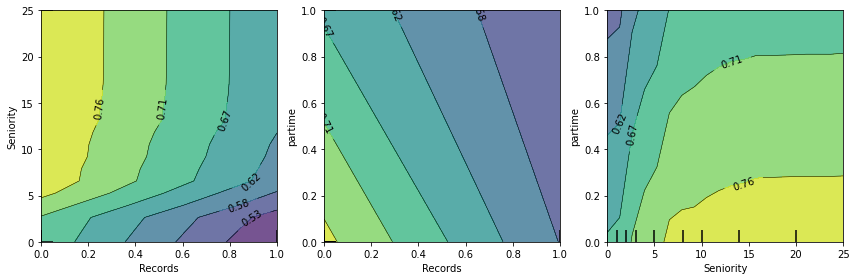

In [49]:
# Feed in the interaction as a nested list
interacted_features = [['Records','Seniority'],['Records','partime'],['Seniority','partime']] 

# Then business as usual when plotting
fig, ax = plt.subplots(figsize=(12, 4))
display = plot_partial_dependence(
    rf_mod, train_X, interacted_features,
    n_cols=3,n_jobs=4, grid_resolution=20,ax=ax
)
fig.tight_layout()

The results indicate that:
People with existence of records and partime job have lower likelihood of good credit status, this effect is amplified when both conditions of both are satisfied. When year of working higher than 5, regardless of the existence of records, the person have a more than 76% chance to be in good credit startus. A person with a year of working higher than 6 and not in a partime job have a more than 76% chance to be in good credit status. 

#### (c) Plot an ICE plot for the most important variable. Is there any heterogeneity in the marginal effect across observations? If so, what might this mean?

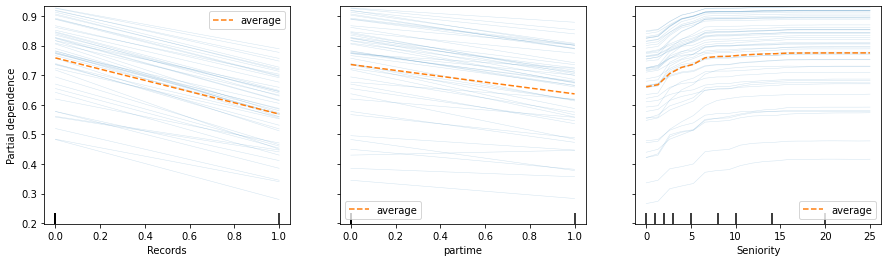

In [50]:
features = ['Records','partime', 'Seniority']
fig, ax = plt.subplots(figsize=(15, 4))
display = PartialDependenceDisplay.from_estimator(
    rf_mod,
    train_X,
    features,
    kind="both", # "average" = just PDP, "individual" = just ICE
    subsample=50,
    n_jobs=3,
    grid_resolution=20,
    random_state=0,
    ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
    pd_line_kw={"color": "tab:orange", "linestyle": "--"},
    n_cols=len(features),
    ax = ax
)
display.figure_.subplots_adjust(hspace=0.3)

According to the ICE plot, there is little heterogeneity in the three most important variables, meaning that for each individuls, the seperate correlations between 'Records','partime', 'Seniority' and credit status follow a almost similar change pattarn. If we take a closer look at the "Seniority", we would find that for some individuls who have lower likelihood of gaining a good credit status,the likelihood of good credit status increse more faster as their year of working increas.   

#### 7. Formulate at least one hypothesis from any insights drawn from the machine learning model. What would be your next steps if you were to explore this analysis further? 

From the machine learning part, we could see that a person's job nature(whether partime job or not), the year of working experience play important role in his/her credit status. For futher study, I may subdivide the work type into more classes and to see each category's influence on a person's crediit status. 